# [Machine Learning with CoreML](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-core-ml)
**By:** Joshua Newnham (Author)  
**Publisher:** [Packt Publishing](https://www.packtpub.com/) 

## Chapter 7 - Fast Neural Style Transfer 
In the notebook [NeuralStyleTransfer_Training_Complete](https://github.com/PacktPublishing/Machine-Learning-with-Core-ML/blob/master/Chapter06/Notebooks/Training/NeuralStyleTransfer_Training_Complete.ipynb) we introduced (albeit at a highlevel) how we can measure content and style and used this to generate a image where the model would optimise the generated image to satisify the content and style loss.  

This is an optimisation problem; where the model optimises the generated image (as described above) **but** the implication of this is that it's computational expensive (i.e. takes a long time). In this notebook we introduce Fast Neural Style Transfer; we omit a lot of the details (reference below to learn more) but in essence we trade-in flexibility for efficiency. Instead of optimising a image, we train a model for a specific style which results in being able to perform style transfer with a single pass through the trained network. The image below illustrates both approaches to help you contrast them.  

<img src="images/fast_style_transfer.jpg" width="80%" />

## Perceptual Losses for Real-Time Style Transfer and Super-Resolution

Keras implementation of the network described in <a href='https://arxiv.org/abs/1603.08155'>Perceptual Losses for Real-Time Style Transfer and Super-Resolution by Justin Johnson, Alexandre Alahi, Li Fei-Fei</a> in in March 2016. 

The implementation is based on what was described in the <a href='http://course.fast.ai/lessons/lesson9.html'>FastAI's course on Generative Models</a>.

In [1]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.0.6'

In [2]:
%matplotlib inline

import importlib

import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import numpy as np
from PIL import Image # used to load images
import glob 

import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K

from vgg16_avg import VGG16_Avg

In [3]:
TARGET_SIZE = (320,320)

## Training Data 

Dataset from Fast.ai and can be downloaded from <a href='http://files.fast.ai/data/imagenet-sample-train.tar.gz'>here</a>. 

In [5]:
#path = '/data/datasets/imagenet/samples/'
path = '/image_data/'

In [6]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [7]:
fn = fnames[50]
fn

'/image_data/n02100877/n02100877_3971.JPEG'

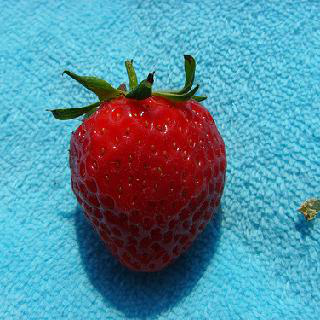

In [12]:
img=Image.open(fnames[80])
img

### Preprocessing 

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

In [13]:
def load_resize_image(img_path, target_size=TARGET_SIZE, preprocess_required=False):
    """
    
    """
    # Load image 
    img = Image.open(img_path)
    if img.mode is not "RGB":
        img = img.convert('RGB')
    
    if preprocess_required:
        # Get dimensions
        img_width, img_height = img.size
        half_img_width, half_img_height = img_width/2.0, img_height/2.0

        # Crop
        target_width = min(img_width, img_height)
        target_height = min(img_width, img_height)

        left = half_img_width - target_width/2
        top = half_img_height - target_height/2
        right = half_img_width + target_width/2
        bottom = half_img_height + target_height/2

        img = img.crop((left, top, right, bottom))

        # Resize 
        img = img.resize(target_size)
    
    return img 

In [14]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

In [15]:
def preproc(x):     
    return (x-rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [16]:
def deproc(x, shape):
    return np.clip(x.reshape(shape)[:, :, :, ::-1] + rn_mean, 0, 255)

## Define the model 

To start we'll define some of the building blocks of our network. In particular recall the residual block (as used in Resnet), which is just a sequence of 2 convolutional layers that is added to the initial block input. We also have a de-convolutional layer (also known as a "transposed convolution" or "fractionally strided convolution"), whose purpose is to learn to "undo" the convolutional function. It does this by padding the smaller image in such a way to apply filters on it to produce a larger image.

In [17]:
class ReflectionPadding2D(keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)        
        self.input_spec = [keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [18]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = keras.layers.Conv2D(filters, kernel_size=(size, size), strides=stride, padding=mode)(x)
    x = keras.layers.BatchNormalization()(x)
    return keras.layers.Activation('relu')(x) if act else x

In [19]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = keras.layers.Conv2D(filters, kernel_size=(size, size), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    return keras.layers.Activation('relu')(x)

In [20]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = keras.layers.Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return keras.layers.add([x, ip])    
    #return keras.layers.merge([x, ip], mode='sum')

Load the style image 

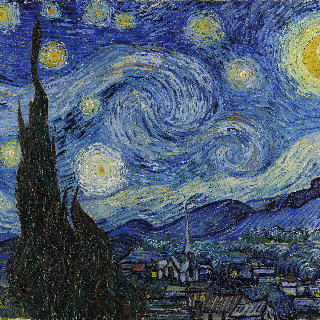

In [21]:
style = load_resize_image('data/Van_Gogh-Starry_Night.jpg', preprocess_required=True)
style

In [22]:
style_arr = preproc(np.expand_dims(np.array(style), 0))
shp = style_arr.shape
shp = shp[1:]
shp

(320, 320, 3)

In [23]:
inp=keras.layers.Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=keras.layers.Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
outp=keras.layers.Lambda(lambda x: (x+1)*127.5)(x)

In [24]:
vgg_inp=keras.layers.Input(shp)
vgg = VGG16(include_top=False, input_tensor=keras.layers.Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

58785792/58889256 [============================>.] - ETA: 0s

In [25]:
def get_outp(m, ln): 
    return m.get_layer("block{}_conv2".format(ln)).output    

In [26]:
vgg_content = keras.models.Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

In [27]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [28]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 160, 160, 128], dtype=int32),
 array([  1,  80,  80, 256], dtype=int32),
 array([  1,  40,  40, 512], dtype=int32),
 array([  1,  20,  20, 512], dtype=int32)]

In [29]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

Our loss now includes the mse for the content loss and the gram matrix for the style

In [30]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [31]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [32]:
w=[0.1, 0.2, 0.6, 0.1]

def tot_loss(x):
    loss = 0 
    n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [33]:
loss = keras.layers.Lambda(tot_loss)(vgg1+vgg2)
m_style = keras.models.Model([inp, vgg_inp], loss)

In [34]:
BATCH_SIZE = 1000
#targ = np.zeros((arr_hr.shape[0], 1))
targ = np.zeros((BATCH_SIZE, 1))

In [35]:
len(fnames) // BATCH_SIZE

19

---

In [36]:
m_style.compile('adam', 'mae')

In [37]:
EPOCS = 2 
for e in range(EPOCS):
    for i in range(len(fnames) // BATCH_SIZE):
        # load images 
        s_idx = i * BATCH_SIZE
        e_idx = min(s_idx + BATCH_SIZE, len(fnames)) 
        batch_fnames = fnames[s_idx:e_idx]
        x_batch = np.zeros((BATCH_SIZE, TARGET_SIZE[0], TARGET_SIZE[1], 3))
        for j in range(len(batch_fnames)):
            # Load image 
            img = load_resize_image(batch_fnames[j])                
            # convert image to array and preprocess for vgg         
            img = np.asarray(img, dtype='float32')
            x_batch[j] = img
        
        m_style.fit([x_batch, x_batch], targ, 8, 1)

Epoch 1/1
1000/1000 [==============================] - 333s - loss: 735.7354   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 519.8411   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 456.1901   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 459.5395   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 450.2950   
Epoch 1/1
1000/1000 [==============================] - 326s - loss: 456.5485   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 432.1485   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 431.8741   
Epoch 1/1
1000/1000 [==============================] - 326s - loss: 434.7375   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 418.8638   
Epoch 1/1
1000/1000 [==============================] - 326s - loss: 409.7918   
Epoch 1/1
1000/1000 [==============================] - 327s - loss: 396.1697   
Epoch 1/1
1000/1000 [===================

--- 

In [ ]:
K.set_value(m_style.optimizer.lr, 1e-4)

In [ ]:
EPOCHS = 1 
for e in range(EPOCHS):
    for i in range(len(fnames) // BATCH_SIZE):
        # load images 
        s_idx = i * BATCH_SIZE
        e_idx = min(s_idx + BATCH_SIZE, len(fnames)) 
        batch_fnames = fnames[s_idx:e_idx]
        x_batch = np.zeros((BATCH_SIZE, TARGET_SIZE[0], TARGET_SIZE[1], 3))
        for j in range(len(batch_fnames)):
            # Load image 
            img = load_resize_image(batch_fnames[j])                
            # convert image to array and preprocess for vgg         
            img = np.asarray(img, dtype='float32')
            x_batch[j] = img

        m_style.fit([x_batch, x_batch], targ, 16, 1)

Epoch 1/1
1000/1000 [==============================] - 313s - loss: 367.2220   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 369.3140   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 363.2702   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 368.0796   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 367.6213   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 373.7924   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 368.8819   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 363.9105   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 368.0236   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 368.2685   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 366.3880   
Epoch 1/1
1000/1000 [==============================] - 301s - loss: 362.9698   
Epoch 1/1
1000/1000 [===================

In [ ]:
top_model = keras.models.Model(inp, outp)

In [ ]:
img = load_resize_image(fnames[80]) 
img = np.asarray(img, dtype='float32')
img = np.expand_dims(img, 0)
p = top_model.predict(img)

In [ ]:
plt.imshow(np.round(p[0]).astype('uint8'));

In [ ]:
img = load_resize_image(fnames[50]) 
img = np.asarray(img, dtype='float32')
img = np.expand_dims(img, 0)
p = top_model.predict(img)
plt.imshow(np.round(p[0]).astype('uint8'));

In [ ]:
img = load_resize_image('data/cat.jpg', preprocess_required=True) 
img = np.asarray(img, dtype='float32')
img = np.expand_dims(img, 0)
p = top_model.predict(img)
plt.imshow(np.round(p[0]).astype('uint8'));

In [ ]:
img = load_resize_image('data/london_big-ben.jpg', preprocess_required=True) 
img = np.asarray(img, dtype='float32')
img = np.expand_dims(img, 0)
p = top_model.predict(img)
plt.imshow(np.round(p[0]).astype('uint8'));

In [ ]:
top_model.save_weights('/output/van-gogh-starry-night_style_2.h5')

In [ ]:
# save as JSON
with open('/output/van-gogh-starry-night_style_2.json', 'w') as f:
    json_string = top_model.to_json()
    f.write(json_string)